Paquetes necesarios

In [171]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

#Identificación de monedas

Carga imagen y convierte a RGB

(938, 473, 3)


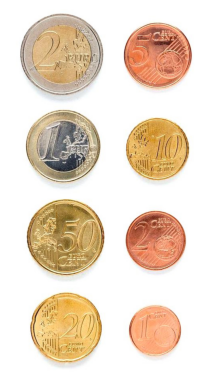

In [172]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

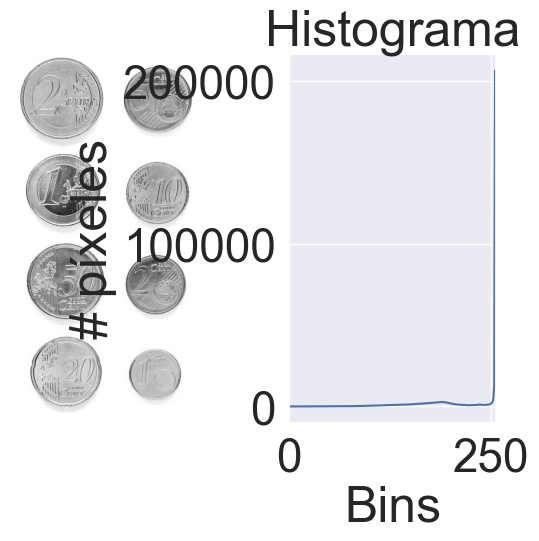

In [173]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])
# Separo subplots horizontalmente
plt.subplots_adjust(wspace=0.4)

Cuenta resultado tras umbralizar (poniendo a negro el fondo)

Umbral fijo usado  200.0
Umbral Otsu  204.0


Text(0.5, 1.0, 'OTSU invertida')

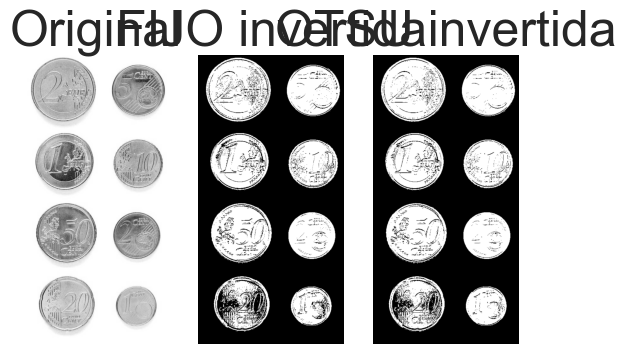

In [174]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


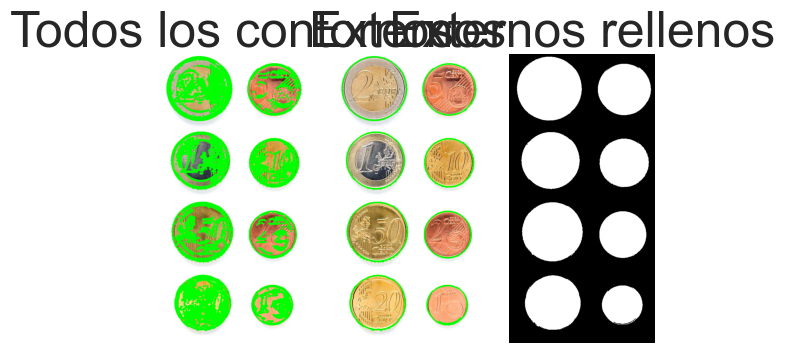

In [175]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)

#Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

#Dibuja sobre la imagen de entrada los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos puede interesará mostrar los valores obtenidos del contorno
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


Alternativa contando círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


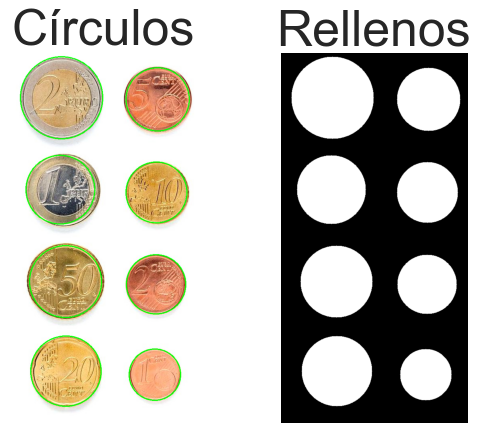

In [176]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

Las formas localizadas tienen distintas características geométricas, que pueden estimarse a partir de sus contornos. Más información en la [documentación de OpenCV](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html).

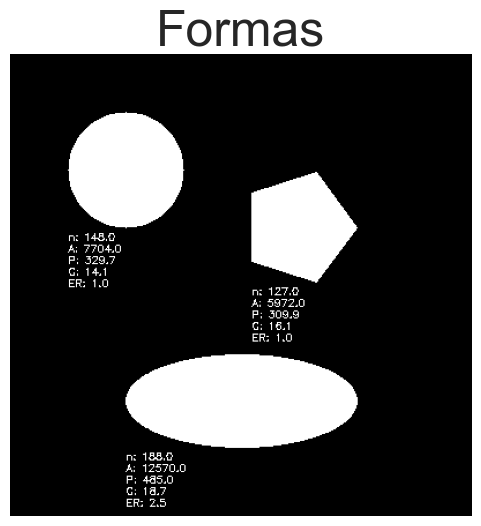

In [177]:
#Creación de polígono regular
def poligono_regular(image, ctr, radio, lados, color):
    pts = []
    ang_step = 2 * np.pi / lados
    for i in range(lados):
        ang = i * ang_step
        x = int(ctr[0] + radio * np.cos(ang))
        y = int(ctr[1] + radio * np.sin(ang))
        pts.append((x, y))
    pts = np.array(pts, np.int32)
    #regorganiza
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image, [pts], color=color)

# Imagen vacía
img = np.zeros((400, 400, 1), dtype="uint8")
color = (255, 255, 255)

# Formas básicas
cv2.circle(img, (100, 100), 50, color, -1)  # Circular
poligono_regular(img, (250, 150), 50, 5, color)  # Polígono regular
cv2.ellipse(img, (200, 300), (100, 40), 0, 0, 360, color, -1)  # Elíptica

# Localiza contornos
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Parámeros texto
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.3
thickness = 1

# Process each contour to calculate compactness and ellipse ratio (if possible)
for c in contours:
    # Puntos del contorno
    clon = len(c)

    # Área y perímetro
    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)

    #Contenedor alineado con ejes de la imagen
    x,y,w,h = cv2.boundingRect(c)
    
    # Compactness: 4*pi*Area/Perimeter^2
    if perimetro > 0:
        compacidad = (perimetro ** 2) / area
    else:
        compactness = 0
    
    # Ajusta elipse si hay suficientes puntos
    if clon >= 5:
        elipse = cv2.fitEllipse(c)
        (center, axes, orientation) = elipse
        major_axis = max(axes)
        minor_axis = min(axes)
        elipse_ratio = major_axis / minor_axis
    else:
        elipse_ratio = None
    
    # Muestra valores en imageb
    cv2.putText(img, f"n: {clon:.1f}", (x, int(y+h+10)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"A: {area:.1f}", (x, int(y+h+20)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"P: {perimetro:.1f}", (x, int(y+h+30)), font, font_scale, color, thickness)
    cv2.putText(img, f"C: {compacidad:.1f}", (x, int(y+h+40)), font, font_scale, color, thickness)
    cv2.putText(img, f"ER: {elipse_ratio:.1f}", (x, int(y+h+50)), font, font_scale, color, thickness)
    
# Visualiza la imagen
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Formas")
plt.axis('off')
plt.show()


TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



In [206]:
# Configuración para mostrar imágenes en Jupyter
def mostrar_imagen(img, titulo="Imagen", cmap=None):
    plt.figure(figsize=(10, 8))
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Diámetros de monedas en mm
diametros_mm = {
    2.00: 25.75,
    1.00: 23.25,
    0.50: 24.25,
    0.20: 22.25,
    0.10: 19.75,
    0.05: 21.25,
    0.02: 18.75,
    0.01: 16.25
}

# Variables globales
pixel_per_mm = None
moneda_referencia = None
moneda_seleccionada = None

# Cargar y procesar imagen
coins = cv2.imread("Monedas3.jpg")
original = coins.copy()

# Preprocesamiento
gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)  # CORRECCIÓN
blur = cv2.GaussianBlur(gray, (9,9), 0)

# Detección de bordes
canny = cv2.Canny(blur, 25, 70)

# Dilatar para cerrar posibles gaps
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(canny, kernel, iterations=2)

# Encontrar contornos
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por área mínima
min_area = 1000  # Ajustar según tamaño de imagen
contours = [c for c in contours if cv2.contourArea(c) > min_area]

print(f"Contornos encontrados: {len(contours)}")


Contornos encontrados: 17


Monedas detectadas: 15


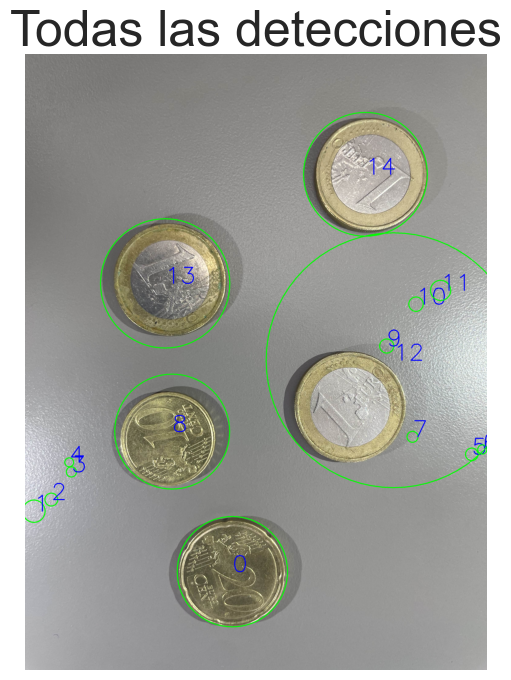

In [207]:
# PASO 1: Detectar TODOS los contornos posibles (umbral muy bajo)
monedas = []
img_monedas = coins.copy()

for i, cont in enumerate(contours):
    # Usar minEnclosingCircle para detectar círculos
    (x, y), radius = cv2.minEnclosingCircle(cont)
    center = (int(x), int(y))
    radius = int(radius)
    
    # Calcular circularidad
    area = cv2.contourArea(cont)
    perimeter = cv2.arcLength(cont, True)
    if perimeter > 0:
        circularity = 4 * np.pi * area / (perimeter * perimeter)
    else:
        circularity = 0
    
    # UMBRAL MUY BAJO para detectar TODO
    if circularity > 0.05:  # Bajamos el umbral para detectar todas las monedas
        monedas.append({
            'id': len(monedas),
            'center': center,
            'radius': radius,
            'diameter_px': radius * 2,
            'contour': cont,
            'circularity': circularity,
            'area': area
        })
        
        # Dibujar círculo
        cv2.circle(img_monedas, center, radius, (0, 255, 0), 5)
        cv2.putText(img_monedas, str(len(monedas)-1), center, 
                   cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 5)

print(f"Monedas detectadas: {len(monedas)}")
mostrar_imagen(img_monedas, "Todas las detecciones")

In [208]:
# Función para calibrar con moneda de referencia
def calibrar_con_moneda_referencia(monedas, id_moneda, valor_euro):
    global pixel_per_mm, moneda_referencia
    
    if id_moneda >= len(monedas):
        print("ID de moneda inválido")
        return False
    
    moneda_ref = monedas[id_moneda]
    diametro_px = moneda_ref['diameter_px']
    diametro_mm = diametros_mm[valor_euro]
    
    pixel_per_mm = diametro_px / diametro_mm
    moneda_referencia = valor_euro
    
    print(f"Calibración completada:")
    print(f"Moneda de {valor_euro}€: {diametro_mm}mm = {diametro_px}px")
    print(f"Relación: {pixel_per_mm:.2f} píxeles/mm")
    
    return True

# Pedir al usuario que identifique una moneda de 1€
print("Identifica el ID de una moneda de 1 euro en la imagen anterior:")
id_referencia = int(input("Ingresa el ID: "))
calibrar_con_moneda_referencia(monedas, id_referencia, 1.00)

Identifica el ID de una moneda de 1 euro en la imagen anterior:
Calibración completada:
Moneda de 1.0€: 23.25mm = 846px
Relación: 36.39 píxeles/mm


True


Moneda ID 1 no identificada:
  Mejor candidato: 0.01€ con error 75.3%
  Diámetro detectado: 4.01mm
  Circularidad: 0.10

Moneda ID 2 no identificada:
  Mejor candidato: 0.01€ con error 85.8%
  Diámetro detectado: 2.31mm
  Circularidad: 0.13

Moneda ID 3 no identificada:
  Mejor candidato: 0.01€ con error 88.8%
  Diámetro detectado: 1.81mm
  Circularidad: 0.14

Moneda ID 4 no identificada:
  Mejor candidato: 0.01€ con error 90.2%
  Diámetro detectado: 1.59mm
  Circularidad: 0.13

Moneda ID 5 no identificada:
  Mejor candidato: 0.01€ con error 86.1%
  Diámetro detectado: 2.25mm
  Circularidad: 0.12

Moneda ID 6 no identificada:
  Mejor candidato: 0.01€ con error 89.9%
  Diámetro detectado: 1.65mm
  Circularidad: 0.15

Moneda ID 7 no identificada:
  Mejor candidato: 0.01€ con error 87.8%
  Diámetro detectado: 1.98mm
  Circularidad: 0.23

Moneda ID 9 no identificada:
  Mejor candidato: 0.01€ con error 84.4%
  Diámetro detectado: 2.53mm
  Circularidad: 0.19

Moneda ID 10 no identificada:
 

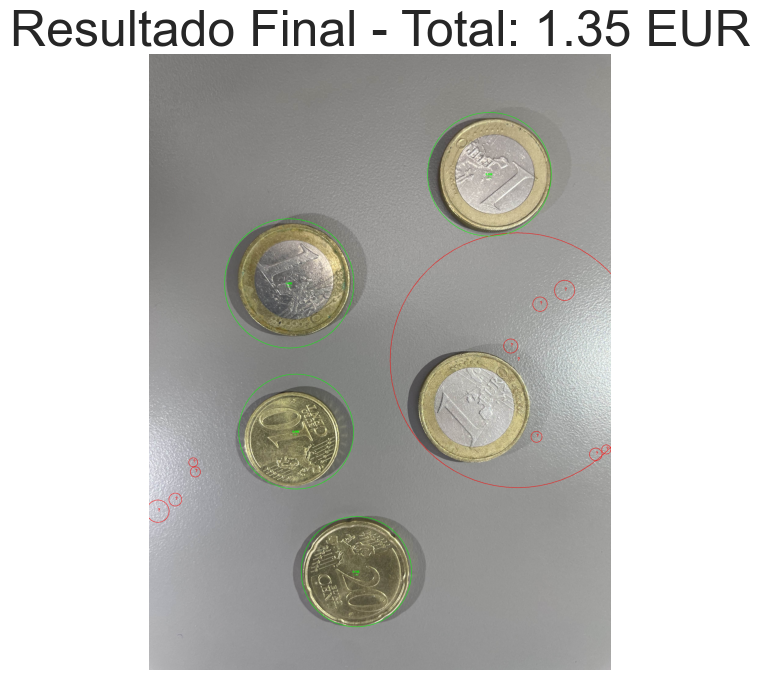

In [209]:
# PASO 2: Clasificación MEJORADA con múltiples criterios
def clasificar_monedas_mejorado(monedas):
    if pixel_per_mm is None:
        print("Primero debes calibrar con una moneda de referencia")
        return None, 0
    
    resultados = []
    total = 0
    img_resultado = coins.copy()
    
    for moneda in monedas:
        diametro_mm = moneda['diameter_px'] / pixel_per_mm
        
        # Calcular puntuación para cada tipo de moneda
        puntuaciones = []
        
        for valor, diam_real in diametros_mm.items():
            # Error en diámetro
            error_diametro = abs(diametro_mm - diam_real) / diam_real
            
            # Bonus por circularidad (las monedas reales son muy circulares)
            bonus_circularidad = moneda['circularity']
            
            # Penalización por tamaño muy diferente
            ratio_tamaño = diametro_mm / diam_real
            if ratio_tamaño > 1.3 or ratio_tamaño < 0.7:
                penalizacion_tamaño = 10.0  # Penalización alta
            else:
                penalizacion_tamaño = 0.0
            
            # Puntuación total (menor es mejor)
            puntuacion = error_diametro + penalizacion_tamaño - (bonus_circularidad * 0.1)
            
            puntuaciones.append({
                'valor': valor,
                'puntuacion': puntuacion,
                'error_diametro': error_diametro,
                'diametro_real': diam_real,
                'diametro_detectado': diametro_mm
            })
        
        # Encontrar la mejor coincidencia
        mejor_match = min(puntuaciones, key=lambda x: x['puntuacion'])
        
        # Umbral de confianza
        if mejor_match['error_diametro'] < 0.15:  # 15% de error máximo
            moneda['valor'] = mejor_match['valor']
            moneda['diametro_mm'] = diametro_mm
            moneda['confianza'] = 1 - mejor_match['error_diametro']
            moneda['detalles'] = mejor_match
            total += mejor_match['valor']
            resultados.append(moneda)
            
            # Dibujar con color según confianza
            if moneda['confianza'] > 0.9:
                color = (0, 255, 0)  # Verde - alta confianza
            elif moneda['confianza'] > 0.85:
                color = (0, 255, 255)  # Amarillo - confianza media
            else:
                color = (0, 165, 255)  # Naranja - baja confianza
            
            cv2.circle(img_resultado, moneda['center'], moneda['radius'], color, 2)
            
            # Mostrar valor y confianza
            texto = f"{mejor_match['valor']:.2f}E"
            cv2.putText(img_resultado, texto, 
                       (moneda['center'][0]-25, moneda['center'][1]+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            # Mostrar confianza
            conf_texto = f"{moneda['confianza']*100:.0f}%"
            cv2.putText(img_resultado, conf_texto, 
                       (moneda['center'][0]-20, moneda['center'][1]+25),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
        else:
            # Marcar como no identificada
            cv2.circle(img_resultado, moneda['center'], moneda['radius'], (0, 0, 255), 2)
            cv2.putText(img_resultado, "?", moneda['center'],
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            
            print(f"\nMoneda ID {moneda['id']} no identificada:")
            print(f"  Mejor candidato: {mejor_match['valor']}€ con error {mejor_match['error_diametro']*100:.1f}%")
            print(f"  Diámetro detectado: {diametro_mm:.2f}mm")
            print(f"  Circularidad: {moneda['circularity']:.2f}")
    
    return resultados, total, img_resultado

# Usar la función mejorada
resultados, total, img_resultado = clasificar_monedas_mejorado(monedas)

# IMPORTANTE: Agregar estas líneas para mostrar el resultado
if img_resultado is not None:
    mostrar_imagen(img_resultado, f"Resultado Final - Total: {total:.2f} EUR")

In [210]:
# OPCIONAL: Función de diagnóstico para entender qué está pasando
def diagnosticar_clasificacion(monedas):
    """Muestra información detallada para entender los errores"""
    
    print("\n=== DIAGNÓSTICO DE CLASIFICACIÓN ===")
    
    for i, moneda in enumerate(monedas):
        diametro_mm = moneda['diameter_px'] / pixel_per_mm
        print(f"\nMoneda ID {i}:")
        print(f"  Circularidad: {moneda['circularity']:.3f}")
        print(f"  Diámetro detectado: {diametro_mm:.2f}mm ({moneda['diameter_px']}px)")
        print(f"  Candidatos:")
        
        # Mostrar todos los candidatos posibles
        candidatos = []
        for valor, diam_real in diametros_mm.items():
            error = abs(diametro_mm - diam_real) / diam_real * 100
            candidatos.append((error, valor, diam_real))
        
        candidatos.sort(key=lambda x: x[0])  # Ordenar por error
        
        for error, valor, diam_real in candidatos[:3]:  # Top 3 candidatos
            print(f"    {valor}€: {diam_real}mm (error: {error:.1f}%)")

# Ejecutar diagnóstico
diagnosticar_clasificacion(monedas)


=== DIAGNÓSTICO DE CLASIFICACIÓN ===

Moneda ID 0:
  Circularidad: 0.577
  Diámetro detectado: 19.84mm (722px)
  Candidatos:
    0.1€: 19.75mm (error: 0.5%)
    0.02€: 18.75mm (error: 5.8%)
    0.05€: 21.25mm (error: 6.6%)

Moneda ID 1:
  Circularidad: 0.096
  Diámetro detectado: 4.01mm (146px)
  Candidatos:
    0.01€: 16.25mm (error: 75.3%)
    0.02€: 18.75mm (error: 78.6%)
    0.1€: 19.75mm (error: 79.7%)

Moneda ID 2:
  Circularidad: 0.134
  Diámetro detectado: 2.31mm (84px)
  Candidatos:
    0.01€: 16.25mm (error: 85.8%)
    0.02€: 18.75mm (error: 87.7%)
    0.1€: 19.75mm (error: 88.3%)

Moneda ID 3:
  Circularidad: 0.142
  Diámetro detectado: 1.81mm (66px)
  Candidatos:
    0.01€: 16.25mm (error: 88.8%)
    0.02€: 18.75mm (error: 90.3%)
    0.1€: 19.75mm (error: 90.8%)

Moneda ID 4:
  Circularidad: 0.128
  Diámetro detectado: 1.59mm (58px)
  Candidatos:
    0.01€: 16.25mm (error: 90.2%)
    0.02€: 18.75mm (error: 91.5%)
    0.1€: 19.75mm (error: 91.9%)

Moneda ID 5:
  Circularida

In [ ]:
# MEJORA ADICIONAL: Ajuste fino post-clasificación
def ajuste_fino_clasificacion(resultados):
    """Revisa la clasificación y corrige errores obvios"""
    
    # Si hay múltiples monedas del mismo valor, verificar consistencia
    valores_detectados = {}
    for moneda in resultados:
        valor = moneda['valor']
        if valor not in valores_detectados:
            valores_detectados[valor] = []
        valores_detectados[valor].append(moneda['diameter_px'])
    
    # Verificar consistencia
    print("\n=== VERIFICACIÓN DE CONSISTENCIA ===")
    for valor, diametros in valores_detectados.items():
        if len(diametros) > 1:
            std_diametros = np.std(diametros)
            mean_diametros = np.mean(diametros)
            cv_percent = (std_diametros / mean_diametros) * 100
            
            print(f"Monedas de {valor}€:")
            print(f"  Cantidad: {len(diametros)}")
            print(f"  Diámetro promedio: {mean_diametros:.1f}px")
            print(f"  Variación: {cv_percent:.1f}%")
            
            if cv_percent > 5:
                print("  ⚠️ Alta variación - revisar clasificación")

# Ejecutar ajuste fino
if resultados:
    ajuste_fino_clasificacion(resultados)

#Clasificación de microplásticos

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV sobre una imagen de muestras de microplásticos.

Umbral escogido  197.0


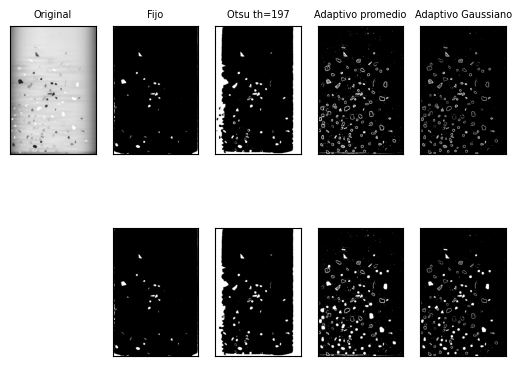

In [76]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs_test.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Para esta imagen de muestras de microplásticos tenemos una anotación (que puede contener errores) de la tipología de las partículas. Esta será la imagen de test en los experimentos posteriores, no puedes hacer uso de esta imagen para entrenar tu clasificador, solo par evaluarlo

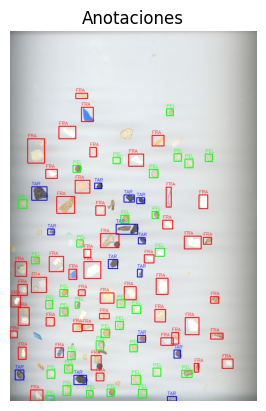

In [77]:
# Imagen y anotaciones
imagen = "MPs_test.jpg"          # Imagen original
csv_file = "MPs_test_bbs.csv"  # CSV con coordenadas y tipología

# Colores de cada clase
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# Imagen
img = cv2.imread(imagen)

# Cara csv y dibujar rectángulos
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        etiqueta = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        
        # Color según etiqueta
        color = colores.get(etiqueta, (0, 0, 0))  # negro por defecto si no encuentra
        
        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Etiqueta 
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Visualiza resultado
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Anotaciones")
plt.axis('off')
plt.show()


##Muestras de entrenamiento

Text(0.5, 1.0, 'Alquitrán')

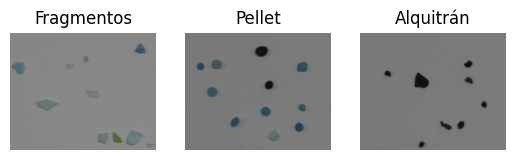

In [78]:
#Cargamos tres subimágenes, por simplicidad, de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

Anotaciones  [3, 1, 1, 0, 1, 0, 1, 0, 3, 2, 2, 2, 3, 1, 0, 3, 3, 3, 2, 3, 3, 3, 0, 0, 2, 3, 1, 1, 3, 3, 1, 3, 0, 0, 3, 2, 2, 3, 2, 3, 2, 1, 1, 3, 2, 3, 0, 1, 1, 1, 0, 2, 2, 1, 3, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2, 2, 3, 1, 0, 0, 0, 3, 2, 2, 2, 2, 3, 2, 0, 0, 2, 1, 1, 2, 2, 1, 1, 0, 3, 0, 0]
Predicciones  [2, 3, 1, 1, 1, 0, 0, 1, 2, 3, 1, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 3, 1, 3, 3, 2, 0, 3, 0, 3, 2, 1, 3, 0, 3, 2, 0, 3, 1, 0, 3, 0, 0, 1, 0, 2, 3, 3, 3, 0, 2, 1, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 0, 0, 2, 1, 3, 3, 0, 3, 0, 3, 3, 2, 1, 0, 0, 1, 1, 3, 2, 2, 0, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 1, 1]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.19
Precision (TP/(TP+FP)) = 0.2199619458128079
Recall (TP/(TP+FN)) = 0.19
F1 Score (2*(precision*recall)/(precision+recall)) = 0.19429044803573775


Text(38.25, 0.5, 'Real/Anotado')

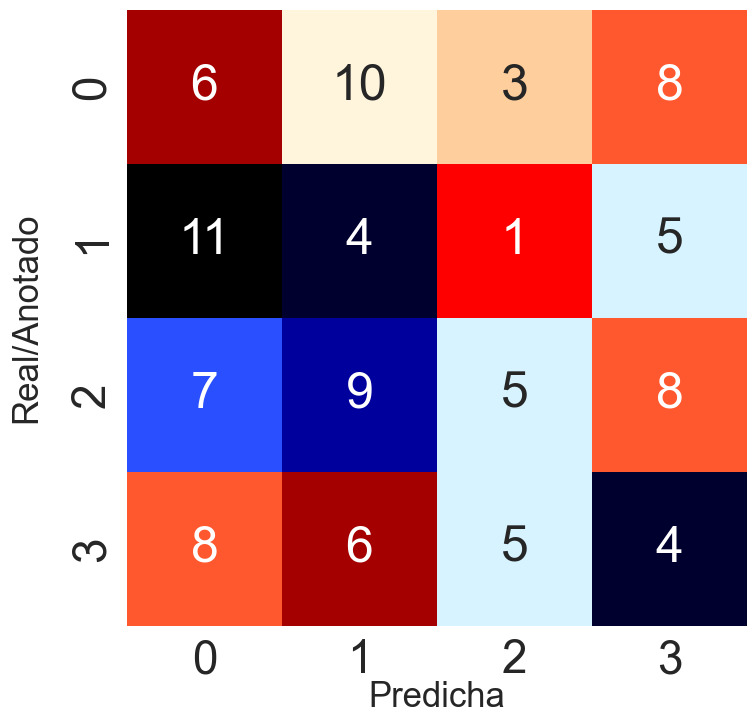

In [79]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.